![Facial Recognition](facialrecognition.jpg)

You are a member of an elite group of data scientists, specialising in advanced facial recognition technology, this firm is dedicated to identifying and safeguarding prominent individuals from various spheres—ranging from entertainment and sports to politics and philanthropy. The team's mission is to deploy AI-driven solutions that can accurately distinguish between images of notable personalities and the general populace, enhancing the personal security of such high-profile individuals. You're to focus on Arnold Schwarzenegger, a figure whose accomplishments span from bodybuilding champion to Hollywood icon, and from philanthropist to the Governor of California. 

### **The Data**
The `data/lfw_arnie_nonarnie.csv` dataset contains processed facial image data derived from the "Labeled Faces in the Wild" (LFW) dataset, focusing specifically on images of Arnold Schwarzenegger and other individuals not identified as him. This dataset has been prepared to aid in the development and evaluation of facial recognition models. There are 40 images of Arnold Schwarzenegger and 150 of other people.

| Column Name | Description |
|-------------|-------------|
| PC1, PC2, ... PCN | Principal components from PCA, capturing key image features. |
| Label | Binary indicator: `1` for Arnold Schwarzenegger, `0` for others. |

In [116]:
# Import required libraries
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Read the CSV file 
df = pd.read_csv("data/lfw_arnie_nonarnie.csv")
# print(df.head())

# Seperate the predictor and class label
X = df.drop('Label', axis=1)
y = df['Label'] 

# Split the data into training and testing sets using stratify to balance the class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

In [117]:
# Import the models you want to use
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Store initialized models in a dictionary
# This approach allows for easy expansion and comparison of different models
models = {
    "LogisticRegression": LogisticRegression(), 
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "XGBClassifier": XGBClassifier()
         }

# Store the model parameters in a dictionary
# Parameters are tailored to each model to explore a range of options during Grid Search
param_grid = {
    "LogisticRegression": {"LogisticRegression__C": [0.01, 0.1, 1, 10, 100]},
    "KNeighborsClassifier": {"KNeighborsClassifier__n_neighbors": range(1, 10)},
    "DecisionTreeClassifier": {
        "DecisionTreeClassifier__max_depth": [1, 2, 5, 10],
        "DecisionTreeClassifier__min_samples_split": [1, 2, 3, 5],
        "DecisionTreeClassifier__splitter": ['best'],
        "DecisionTreeClassifier__max_features": ['log2', 0.5, None],
        "DecisionTreeClassifier__criterion": ['entropy', 'gini'],
        "DecisionTreeClassifier__random_state": [42]
    },
    "XGBClassifier": { 
        "XGBClassifier__max_depth": [8],
        "XGBClassifier__learning_rate": [0.2323287206498131],
        "XGBClassifier__n_estimators": [451],
        "XGBClassifier__subsample": [0.6562724120378075],
        "XGBClassifier__colsample_bytree": [0.9528039699341604],
        "XGBClassifier__eval_metric": ['mlogloss'],
        "XGBClassifier__use_label_encoder": ["False"],
        "XGBClassifier__random_state": [42]
    }
}

In [112]:
from sklearn.model_selection import RandomizedSearchCV

# Example: choose one estimator to tune, e.g., DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    "max_depth": [1, 2, 5, 10],
    "min_samples_split": [2, 3, 5],  # min_samples_split must be at least 2
    "splitter": ['best'],
    "max_features": ['log2', 0.5, None],
    "criterion": ['entropy', 'gini'],
    "random_state": [42]
}

# Use a single estimator, not a dict of models
search = RandomizedSearchCV(
    DecisionTreeClassifier(),
    param_distributions=param_grid,
    n_iter=30,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    random_state=42
)
search.fit(X_train, y_train)
print("Best Parameters:", search.best_params_)
print("Best CV Score:", search.best_score_)

Best Parameters: {'splitter': 'best', 'random_state': 42, 'min_samples_split': 3, 'max_features': 0.5, 'max_depth': 1, 'criterion': 'entropy'}
Best CV Score: 0.7896774193548387


In [106]:
# Optuna is one of the most popular frameworks for Bayesian tuning.
# It’s flexible, faster, and great for complex models like XGBoost or neural nets.import optuna
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False,
        'random_state': 42
    }
    model = XGBClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best params:", study.best_params)
print("Best accuracy:", study.best_value)


[I 2025-11-11 22:00:50,709] A new study created in memory with name: no-name-8c63bccb-e1dd-4046-a60f-0e0da9483d3b
[I 2025-11-11 22:00:51,773] Trial 0 finished with value: 0.7763398692810458 and parameters: {'max_depth': 10, 'learning_rate': 0.25666653872151846, 'n_estimators': 404, 'subsample': 0.6203681200321356, 'colsample_bytree': 0.8219687290935265}. Best is trial 0 with value: 0.7763398692810458.
[I 2025-11-11 22:00:53,241] Trial 1 finished with value: 0.7895424836601307 and parameters: {'max_depth': 7, 'learning_rate': 0.01700567916032144, 'n_estimators': 387, 'subsample': 0.723912128605785, 'colsample_bytree': 0.8635364919304653}. Best is trial 1 with value: 0.7895424836601307.
[I 2025-11-11 22:00:54,396] Trial 2 finished with value: 0.7895424836601307 and parameters: {'max_depth': 3, 'learning_rate': 0.03722754643113459, 'n_estimators': 381, 'subsample': 0.6806735113104544, 'colsample_bytree': 0.6530869086920257}. Best is trial 1 with value: 0.7895424836601307.
[I 2025-11-11 22

Best params: {'max_depth': 6, 'learning_rate': 0.06250953067951182, 'n_estimators': 312, 'subsample': 0.818046268799563, 'colsample_bytree': 0.6315905312608339}
Best accuracy: 0.7962091503267974


In [113]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Corrected param grid
param_grid_1 = {
    "max_depth": [8],
    "learning_rate": [0.13581462862331029],
    "n_estimators": [324],
    "subsample": [0.6035612631026932],
    "colsample_bytree": [0.892008111178083],
    "random_state": [42]
}

search = RandomizedSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    param_distributions=param_grid_1,
    n_iter=30,
    cv=3,
    n_jobs=-1,
    scoring='accuracy',
    random_state=42
)
search.fit(X_train, y_train)
print("Best Parameters:", search.best_params_)
print("Best CV Score:", search.best_score_)

Best Parameters: {'subsample': 0.6035612631026932, 'random_state': 42, 'n_estimators': 324, 'max_depth': 8, 'learning_rate': 0.13581462862331029, 'colsample_bytree': 0.892008111178083}
Best CV Score: 0.8027450980392157


In [108]:
# Import important libraries for models
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.tree import DecisionTreeClassifier

# Store models in dictionary
# This approach allows for easy expansion and comparison of different models
#models ={"RandomForestClassifier": RandomForestClassifier(),
         #"LogisticRegression": LogisticRegression(),
         #"KNeighborsClassifier": KNeighborsClassifier(),
         #"DecisionTreeClassifier": DecisionTreeClassifier()}
# Going in more details for parameter selection
# Define dictionary to store model parameters
# Parameters are tailored to each model to explore a range of options during Grid Search
#param_grid = {
    #"RandomForestClassifier": {
        #"RandomForestClassifier__n_estimators": [100,300,500,1000],
        #"RandomForestClassifier__max_depth" : [5,10,15,25,35],
        #"RandomForestClassifier__min_samples_split":[4],
        #"RandomForestClassifier__min_samples_leaf": [2],
        #"RandomForestClassifier__max_features": ['sqrt'],
        #"RandomForestClassifier__bootstrap": [True],
        #"RandomForestClassifier__class_weight": ['balanced'],
        #"RandomForestClassifier__random_state": [42],
      #  },
    #"LogisticRegression": {
        #"LogisticRegression__penalty":['l2'],
        #"LogisticRegression__C": [0.01, 0.1, 1, 10, 100],
       # "LogisticRegression__solver": ['lbfgs'],
       # "LogisticRegression__max_iter": [1000],
        #"LogisticRegression__multi_class": ['multinomial'],
        #"LogisticRegression__class_weight": ['balanced'],
        #"LogisticRegression__random_state": [42]
       # },
    #"KNeighborsClassifier": {
       # "KNeighborsClassifier__n_neighbors": range(1,10),
       # "KNeighborsClassifier__weights": ['distance'],
        #"KNeighborsClassifier__metric": ['minkowski'],
        #"KNeighborsClassifier__p": [2],
       # "KNeighborsClassifier__algorithm": ['auto'],
       #  },
    #"DecisionTreeClassifier": {
       # "DecisionTreeClassifier__criterion":['entropy','gini'],
        #"DecisionTreeClassifier__max_depth": [5,10,15,None],
       # "DecisionTreeClassifier__min_samples_split": [2,5,10,20],
       # "DecisionTreeClassifier__min_samples_leaf": [1,2,4,8],
        #"DecisionTreeClassifier__max_features":['log2',0.5,0.8,None],
       # "DecisionTreeClassifier__class_weight":['balanced'],
       # "DecisionTreeClassifier__splitter": ['best'],
       # "DecisionTreeClassifier__random_state": [42]}
       
#}

In [118]:
# Define cross-validation parameters
# KFold is used here to ensure that our model generalizes well on unseen data
kf = KFold(n_splits=5, random_state=42, shuffle=True)

# Prepare to collect Grid Search CV results
# Grid Search helps find the best parameter combination for each model
pipe_accuracies = {}
pipe_params = {}
pipelines = {}



for name, model in models.items():
 
    pipeline = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
        (name, model)
    ])
    
   #Create the GridSearchCV object
    grid_search = GridSearchCV(
        pipeline,
        param_grid[name],  
        cv=kf,
        scoring="accuracy",
        n_jobs=-1
    )

In [119]:
# perform grid search and fit the model and store the results
grid_search.fit(X_train, y_train)
pipe_accuracies[name] = grid_search.best_score_
pipe_params[name] = grid_search.best_params_
pipelines[name] = grid_search
print( pipe_accuracies[name])
print(pipe_params[name])
print(pipelines[name])

0.7888172043010753
{'XGBClassifier__colsample_bytree': 0.9528039699341604, 'XGBClassifier__eval_metric': 'mlogloss', 'XGBClassifier__learning_rate': 0.2323287206498131, 'XGBClassifier__max_depth': 8, 'XGBClassifier__n_estimators': 451, 'XGBClassifier__random_state': 42, 'XGBClassifier__subsample': 0.6562724120378075, 'XGBClassifier__use_label_encoder': 'False'}
GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=0.95)),
                                       ('XGBClassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
        

In [90]:
# Select the best model based on the best cross-validation score
best_model_name = max(pipe_accuracies)
best_model_cv_score = max(pipe_accuracies.values())
best_model_info = pipe_params[best_model_name]

# Print the best model name, parameters, and CV score
print(f"Best Model: {best_model_name}")
print(f"Best Model Parameters: {best_model_info}")
print(f"Best Model CV Score: {best_model_cv_score}")


# Compute and print key performance metrics
# These metrics help us understand the model's effectiveness in classification
y_pred = pipelines[best_model_name].predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")




Best Model: LogisticRegression
Best Model Parameters: {'XGBClassifier__colsample_bytree': 0.892008111178083, 'XGBClassifier__eval_metric': 'mlogloss', 'XGBClassifier__learning_rate': 0.13581462862331029, 'XGBClassifier__max_depth': 8, 'XGBClassifier__n_estimators': 324, 'XGBClassifier__random_state': 42, 'XGBClassifier__subsample': 0.6035612631026932, 'XGBClassifier__use_label_encoder': 'False'}
Best Model CV Score: 0.7891503267973855
Accuracy: 0.7895
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


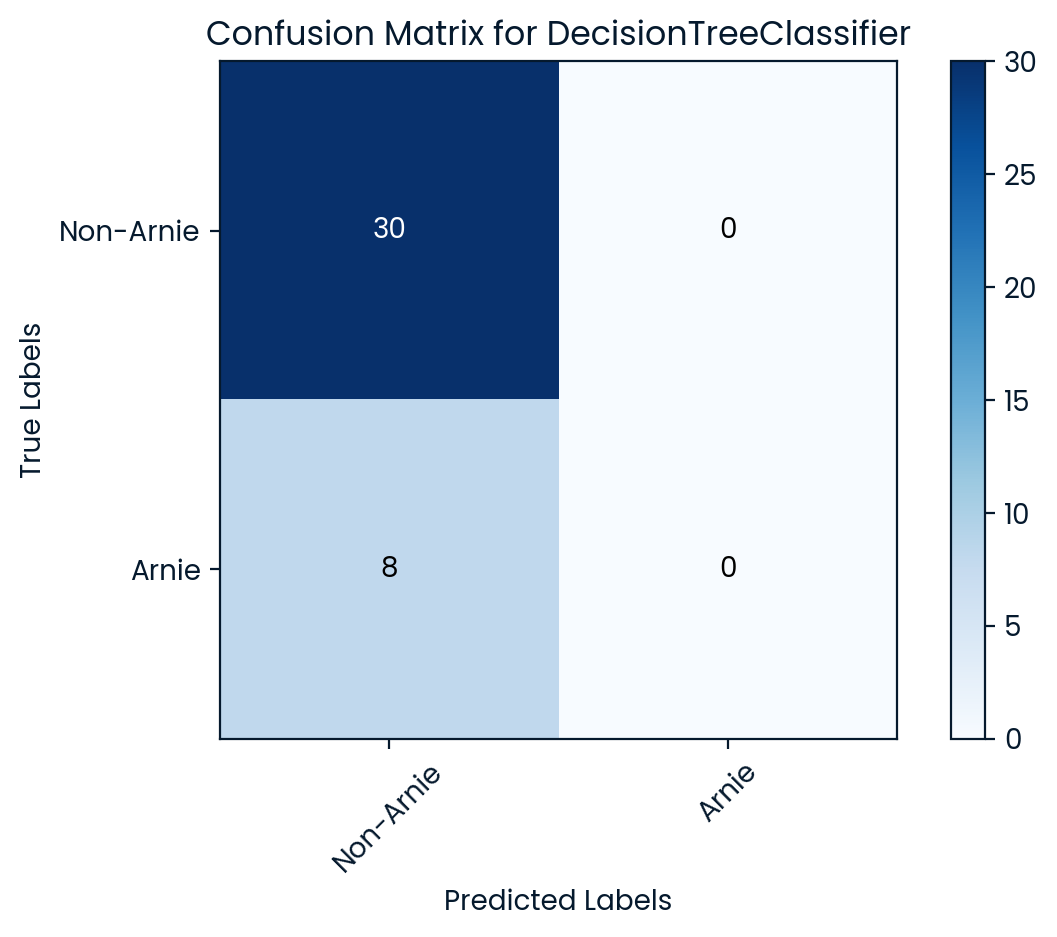

In [37]:
# Visualize the confusion matrix with values using Matplotlib
conf_mat = confusion_matrix(y_test, y_pred)
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for {best_model_name}')
plt.colorbar()
tick_marks = range(len(set(y_test)))
plt.xticks(tick_marks, ['Non-Arnie', 'Arnie'], rotation=45)
plt.yticks(tick_marks, ['Non-Arnie', 'Arnie'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Show values in the confusion matrix
thresh = conf_mat.max() / 2.
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        plt.text(j, i, format(conf_mat[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_mat[i, j] > thresh else "black")

plt.tight_layout()
plt.show()